# 10. 번역기를 만들어보자

|평가문항|상세기준|
|---|---|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
|2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.|seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.|

In [1]:
import pandas as pd
import numpy as np
import unicodedata
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

2023-04-22 19:59:32.764995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 19:59:33.286810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
file_path = os.getcwd()+'/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
105077,I found this under your bed.,J'ai trouvé ceci sous votre lit.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
73502,That would be unethical.,Ce serait contraire à l'éthique.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
154199,You're our one millionth customer.,Vous êtes notre millionième client.,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
140332,Tom knows how to cook spaghetti.,Tom sait préparer les spaghettis.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
16961,They were lucky.,Ils ont eu de la chance.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [3]:
lines = lines[['eng', 'fra']]
lines

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
...,...,...
217970,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
217971,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
217972,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
217973,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


In [4]:
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.head()

전체 샘플의 수 : 217975


,eng,fra
0,Go.,\t Va ! \n
1,Go.,\t Marche. \n
2,Go.,\t En route ! \n
3,Go.,\t Bouge ! \n
4,Hi.,\t Salut ! \n


In [5]:
def to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
  
def preprocess_sentence(sent):
# 악센트 제거 함수 호출
  sent = to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백 추가.
  # ex) "I am a student." => "I am a student ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

In [6]:
# 전처리 테스트
en_sent = "Have you had dinner?"
fr_sent = "Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [7]:
def load_preprocessed_data(num_samples):
    encoder_input, decoder_input, decoder_target = [], [], []
    
    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):
            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [8]:
num_samples=100000
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data(num_samples)
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]


In [9]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (100000, 9)
디코더의 입력의 크기(shape) : (100000, 17)
디코더의 레이블의 크기(shape) : (100000, 17)


In [10]:
print(encoder_input[:5])
print(decoder_input[:5])
print(decoder_target[:5])

[[  41    1    0    0    0    0    0    0    0]
 [  41    1    0    0    0    0    0    0    0]
 [  41    1    0    0    0    0    0    0    0]
 [  41    1    0    0    0    0    0    0    0]
 [1443    1    0    0    0    0    0    0    0]]
[[   2   94   26    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   2  299    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   2   27  537   26    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   2 1174   26    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   2 1543   26    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]
[[  94   26    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [ 299    1    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [  27  537   26    3    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [1174   26    3    0    0    0    0  

In [11]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 8656, 프랑스어 단어 집합의 크기 : 14584


In [12]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [57769 84046 25735 ... 41152 27105 37111]


In [13]:
n_of_val = int(num_samples*0.1)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 10000


In [14]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (90000, 9)
훈련 target 데이터의 크기 : (90000, 17)
훈련 target 레이블의 크기 : (90000, 17)
테스트 source 데이터의 크기 : (10000, 9)
테스트 target 데이터의 크기 : (10000, 17)
테스트 target 레이블의 크기 : (10000, 17)


In [15]:
embedding_dim = 64
hidden_units = 64

# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

2023-04-22 19:59:39.422351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-22 19:59:39.602414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-22 19:59:39.602458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-22 19:59:39.604674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-22 19:59:39.604713: I tensorflow/compile

In [16]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [17]:
hist=model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50


2023-04-22 19:59:46.302252: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2023-04-22 19:59:47.867188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801
2023-04-22 19:59:48.207475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-22 19:59:48.393180: I tensorflow/compiler/xla/servic

704/704 [==============================] - 41s 48ms/step - loss: 2.6672 - acc: 0.6261 - val_loss: 2.4083 - val_acc: 0.6330
Epoch 2/50
704/704 [==============================] - 22s 31ms/step - loss: 1.7096 - acc: 0.7279 - val_loss: 2.0894 - val_acc: 0.6659
Epoch 3/50
704/704 [==============================] - 21s 30ms/step - loss: 1.4760 - acc: 0.7601 - val_loss: 1.8825 - val_acc: 0.6992
Epoch 4/50
704/704 [==============================] - 21s 30ms/step - loss: 1.3114 - acc: 0.7856 - val_loss: 1.7386 - val_acc: 0.7200
Epoch 5/50
704/704 [==============================] - 22s 31ms/step - loss: 1.1912 - acc: 0.8003 - val_loss: 1.6313 - val_acc: 0.7325
Epoch 6/50
704/704 [==============================] - 20s 29ms/step - loss: 1.0921 - acc: 0.8117 - val_loss: 1.5456 - val_acc: 0.7433
Epoch 7/50
704/704 [==============================] - 21s 29ms/step - loss: 1.0075 - acc: 0.8209 - val_loss: 1.4749 - val_acc: 0.7509
Epoch 8/50
704/704 [==============================] - 21s 29ms/step - los

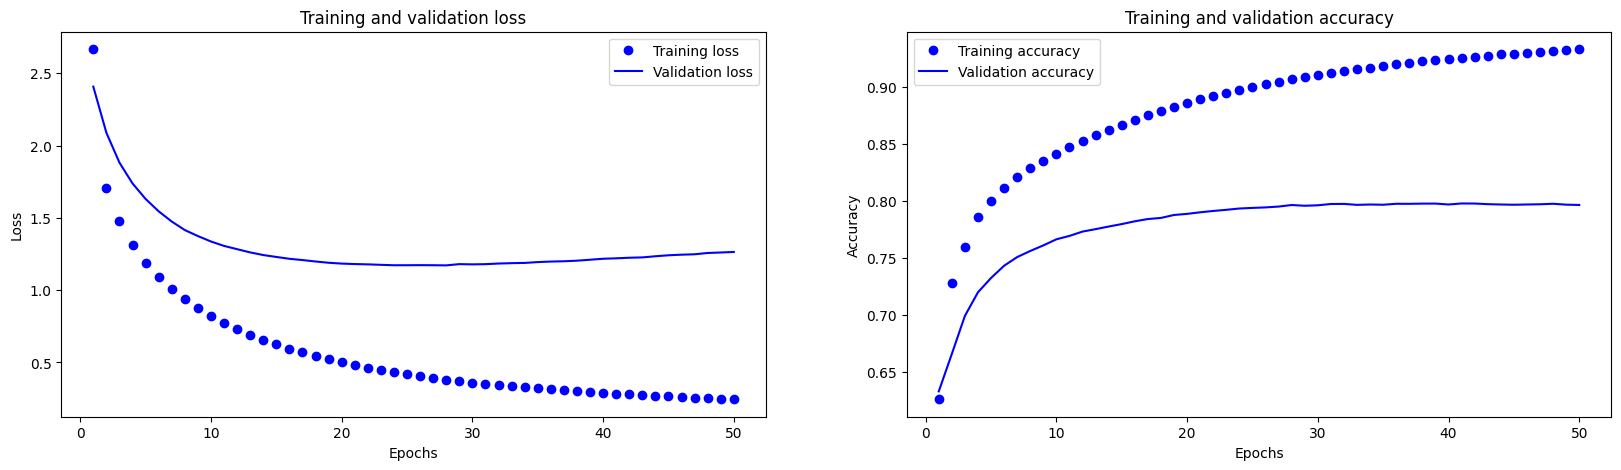

In [18]:
history_dict = hist.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
# "bo"는 "파란색 점"입니다
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

2023-04-22 20:17:50.732211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-22 20:17:50.733650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-22 20:17:50.734895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [20]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [21]:
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [22]:
for seq_index in random.sample(range(1, 10000), 5):
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 16ms/step


2023-04-22 20:17:51.720261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-22 20:17:51.721283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-22 20:17:51.722303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

입력문장 : get down . 
정답문장 : au sol ! 
번역문장 : descends . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : tom is older . 
정답문장 : tom est plus age . 
번역문장 : tom est plus vieux . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : it ll go away . 
정답문장 : ca s evanouira . 
번역문장 : ca va se battre . 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : i was robbed . 
정답문장 : j ai ete cambriole . 
번역문장 : j ai ete cambriole . 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : i m fine . 
정답문장 : ca va . 
번역문장 : ca va bien . 
--------------------------------------------------


In [23]:
for seq_index in random.sample(range(1, 10000), 5):
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 17ms/step
입력문장 : i could help . 
정답문장 : je pourrais aider . 
번역문장 : je pouvais aider . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : i am a monk . 
정답문장 : je suis un moine . 
번역문장 : je suis un moine . 
--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
입력문장 : tea please . 
정답문장 : le the s il vous plait . 
번역문장 : le the s il vous plait . 
--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
입력문장 : i sat down . 
정답문장 : je m assis . 
번역문장 : je m assis . 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : i m clean . 
정답문장 : j ai decroche . 
번역문장 : je suis a l exterieur . 
--------------------------------------------------


번역된 문장들에 대해서 deepl 사이트를 이용하여 번역을 해보았다.  
그 결과는 다음과 같다.

입력문장 : get down . (내려와)  
정답문장 : au sol ! (지상에서)  
번역문장 : descends .  (~로 이동)

입력문장 : tom is older . (톰은 나이가 많습니다.)  
정답문장 : tom est plus age . (톰은 나이가 많습니다.)  
번역문장 : tom est plus vieux . (톰은 나이가 많습니다.)

입력문장 : i could help . (내가 도울 수 있습니다.)  
정답문장 : je pourrais aider . (제가 도와드릴 수 있습니다.)  
번역문장 : je pouvais aider . (제가 도와드릴 수 있습니다.)

위와 같이 번역을 한 문장들도 나름 의미가 잘 통하는 것을 알 수 있다.  

validation loss의 경우 처음에는 우하향하는 곡선을 그렸으나 학습이 진행됨에 따라 과적합 되면서 조금씩 증가하는 경향을 보인다.  
하지만 loss가 조금씩 올라가긴하지만 정확도도 조금씩 올라가는 모습을 보였기에 loss값이 조금 올라가더라고 정확도를 높이는것이 중요하다고 생각해 epoch를 크게 잡았다.

이번 학습에서 의외였던 것은 데이터를 10만개로 상당히 많이 했음에도 학습하는데 오랜 시간이 걸리지 않았다는것이다.  
다음에 또 비슷한 nlp 학습을 진행할 때 비교하면 좋을 것 같다.